In [1]:
import csv
import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import keras
from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Input
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import keras.backend as K

from keras.models import Model
from keras.layers import Input, Flatten, Dropout, Concatenate, Activation
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils.data_utils import get_file

WEIGHTS_PATH = 'https://github.com/wohlert/keras-squeezenet/releases/download/v0.1/squeezenet_weights.h5'

def _fire(x, filters, name="fire"):
    sq_filters, ex1_filters, ex2_filters = filters
    squeeze = Convolution2D(sq_filters, (1, 1), activation='relu', padding='same', name=name + "squeeze1x1")(x)
    expand1 = Convolution2D(ex1_filters, (1, 1), activation='relu', padding='same', name=name + "expand1x1")(squeeze)
    expand2 = Convolution2D(ex2_filters, (3, 3), activation='relu', padding='same', name=name + "expand3x3")(squeeze)
    x = Concatenate(axis=-1, name=name)([expand1, expand2])
    return x

def SqueezeNet(include_top=True, weights="imagenet", input_tensor=None, input_shape=None, pooling=None, classes=1000):

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = Convolution2D(64, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu", name='conv1')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool1', padding="valid")(x)

    x = _fire(x, (16, 64, 64), name="fire2")
    x = _fire(x, (16, 64, 64), name="fire3")

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool3', padding="valid")(x)

    x = _fire(x, (32, 128, 128), name="fire4")
    x = _fire(x, (32, 128, 128), name="fire5")

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='maxpool5', padding="valid")(x)

    x = _fire(x, (48, 192, 192), name="fire6")
    x = _fire(x, (48, 192, 192), name="fire7")

    x = _fire(x, (64, 256, 256), name="fire8")
    x = _fire(x, (64, 256, 256), name="fire9")

    if include_top:
        x = Dropout(0.5, name='dropout9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = AveragePooling2D(pool_size=(13, 13), name='avgpool10')(x)
        x = Flatten(name='flatten10')(x)
        x = Activation("softmax", name='softmax')(x)
    else:
        if pooling == "avg":
            x = GlobalAveragePooling2D(name="avgpool10")(x)
        else:
            x = GlobalMaxPooling2D(name="maxpool10")(x)

    model = Model(img_input, x, name="squeezenet")

    if weights == 'imagenet':
        weights_path = get_file('squeezenet_weights.h5',
                                WEIGHTS_PATH,
                                cache_subdir='models')

        model.load_weights(weights_path, )

    return model

# read the CSV into memory
prices = []
image_paths = []

data_path = "../datasets/bikes_im/"
with open("../datasets/bikes_classified.csv") as file:
    reader = csv.reader(file)
    i = -1
    for row in reader:
        i += 1
        index = row[0]
        name = row[1]
        msrp = row[2]
        label = row[3]
        
        image_path = data_path + index + '.jpg'
        image_paths.append(image_path)
        prices.append(str(label))
        
train_indices = np.load("bikes_train_indices.npy")
test_indices = np.load("bikes_test_indices.npy")
print(train_indices.shape)
print(test_indices.shape)

def image_generator(indices, batch_size):

    num_batches = int(len(indices) / batch_size)
    
    while True:
        for batch_i in range(num_batches):
            if batch_i == num_batches - 1:
                # special case: return as many as possible
                start_i = batch_i * batch_size
                batch_indices = indices[start_i:]
                
                X = np.zeros((len(batch_indices), 224, 224, 3))
                Y = np.zeros((len(batch_indices), 4)) # Change to one-hot
            
            else:
                start_i = batch_i * batch_size
                end_i = start_i + batch_size

                batch_indices = indices[start_i:end_i]

                X = np.zeros((batch_size, 224, 224, 3))
                Y = np.zeros((batch_size, 4)) # Change to one-hot
            
            for i, index in enumerate(batch_indices):
                img = image.load_img(image_paths[index], target_size=(224, 224))
                X[i, :, :, :] = image.img_to_array(img)
                # Convert to 1 hot vector
                p = prices[index]
                if p == "25":
                    Y[i,:] = np.array([1,0,0,0])
                if p == "50":
                    Y[i,:] = np.array([0,1,0,0])
                if p == "75":
                    Y[i,:] = np.array([0,0,1,0])
                if p == "100":
                    Y[i,:] = np.array([0,0,0,1])
            
            # use vgg16 preprocessing
            X = preprocess_input(X)
            
            yield (X, Y)

# Hyperparameters

num_settings = 1

hp_dropout = [0.5] * num_settings

#RMSprop
hp_lr = [0.005] * num_settings
hp_rho = [0.9] * num_settings
hp_epsilon = [1e-07] * num_settings
hp_decay = [0.0] * num_settings

# Number of hidden units
hp_hidden = [256] * num_settings

# Minibatch size
hp_mbsize = [64] * num_settings

num_epochs = 300


Using TensorFlow backend.


(19658,)
(2185,)


In [2]:
# store the results of each setting
train_losses = np.zeros(num_settings)
dev_losses = np.zeros(num_settings)

for setting in range(num_settings):
    model = SqueezeNet(include_top=True)
    
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()
    
    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Convolution2D(256, (1, 1), padding='valid', name='top_conv', input_shape=(model.layers[-1].output_shape[1:])))
    top_model.add(AveragePooling2D(pool_size=(5, 5), name='top_avgpool'))
    top_model.add(Flatten(input_shape=(model.layers[-1].output_shape[1:]),name='top_flatten'))
    top_model.add(Dropout(hp_dropout[setting], name='top_dropout'))
#     top_model.add(Dense(hp_hidden[setting], activation='relu', kernel_initializer='glorot_uniform', name='top_dense'))
    top_model.add(Dense(4, activation='softmax', name='output', kernel_initializer='glorot_uniform'))
    
    # add the model on top of the convolutional base
    new_model = Model(inputs= model.input, outputs = top_model(model.layers[-1].output))
#     new_model = load_model("E:/output/bikes-cnn-PriceNet-Class/{epoch:08d}.hdf5")
    new_model.summary()
    
    # RMSprop optimizer
#     new_model.compile(loss='mean_squared_error',
#                       optimizer=optimizers.RMSprop(
#                               lr=hp_lr[setting], 
#                               rho=hp_rho[setting], 
#                               epsilon=hp_epsilon[setting], 
#                               decay=hp_decay[setting]))
    new_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07, decay=0.0), metrics=['accuracy'])
    
    
    checkpoint_path = 'E:/output/bikes-cnn-SqueezeNet-Class/{epoch:05d}.hdf5'
    
    # keep a checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path, period=5)
    
    
    minibatch_size = hp_mbsize[setting]

    train_steps = math.ceil(len(train_indices) / minibatch_size)
    test_steps = math.ceil(len(test_indices) / minibatch_size)

    # fine-tune the model
    history = new_model.fit_generator(
        image_generator(train_indices, minibatch_size),
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=image_generator(test_indices, minibatch_size),
        nb_val_samples=test_steps,
        callbacks=[checkpoint])
    
   
    print("==========")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 55, 55, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2squeeze1x1 (Conv2D)        (None, 55, 55, 16)   1040        maxpool1[0][0]                   
__________________________________________________________________________________________________
fire2expan

C:\Users\Richard\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:56: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\Richard\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=308, validation_steps=35, callbacks=[<keras.ca..., epochs=300)`


Epoch 1/300
308/308 [==============================] - 76s 246ms/step - loss: 1.1704 - acc: 0.5242 - val_loss: 0.8462 - val_acc: 0.6354
Epoch 2/300
308/308 [==============================] - 61s 197ms/step - loss: 0.7604 - acc: 0.6550 - val_loss: 0.8028 - val_acc: 0.6701
Epoch 3/300
308/308 [==============================] - 60s 193ms/step - loss: 0.6558 - acc: 0.7138 - val_loss: 0.6682 - val_acc: 0.7043
Epoch 4/300
308/308 [==============================] - 58s 187ms/step - loss: 0.5784 - acc: 0.7494 - val_loss: 0.6243 - val_acc: 0.7421
Epoch 5/300
308/308 [==============================] - 56s 181ms/step - loss: 0.5162 - acc: 0.7829 - val_loss: 0.5835 - val_acc: 0.7612
Epoch 6/300
308/308 [==============================] - 56s 180ms/step - loss: 0.4549 - acc: 0.8129 - val_loss: 0.6275 - val_acc: 0.7617
Epoch 7/300
308/308 [==============================] - 55s 179ms/step - loss: 0.4065 - acc: 0.8326 - val_loss: 0.6716 - val_acc: 0.7554
Epoch 8/300
308/308 [===========================

Epoch 61/300
308/308 [==============================] - 55s 177ms/step - loss: 0.0517 - acc: 0.9833 - val_loss: 1.2238 - val_acc: 0.8061
Epoch 62/300
308/308 [==============================] - 54s 176ms/step - loss: 0.0496 - acc: 0.9835 - val_loss: 1.1062 - val_acc: 0.7977
Epoch 63/300
308/308 [==============================] - 54s 176ms/step - loss: 0.0503 - acc: 0.9837 - val_loss: 1.1836 - val_acc: 0.8070
Epoch 64/300
308/308 [==============================] - 54s 176ms/step - loss: 0.0515 - acc: 0.9841 - val_loss: 1.2565 - val_acc: 0.8092
Epoch 65/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0559 - acc: 0.9810 - val_loss: 1.2482 - val_acc: 0.7937
Epoch 66/300
308/308 [==============================] - 55s 177ms/step - loss: 0.0511 - acc: 0.9842 - val_loss: 1.2448 - val_acc: 0.7946
Epoch 67/300
308/308 [==============================] - 54s 176ms/step - loss: 0.0531 - acc: 0.9824 - val_loss: 1.3250 - val_acc: 0.8004
Epoch 68/300
308/308 [===================

308/308 [==============================] - 55s 179ms/step - loss: 0.0459 - acc: 0.9862 - val_loss: 1.7914 - val_acc: 0.7977
Epoch 121/300
308/308 [==============================] - 55s 180ms/step - loss: 0.0449 - acc: 0.9863 - val_loss: 1.4812 - val_acc: 0.8070
Epoch 122/300
308/308 [==============================] - 55s 177ms/step - loss: 0.0410 - acc: 0.9873 - val_loss: 1.7461 - val_acc: 0.8052
Epoch 123/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0409 - acc: 0.9876 - val_loss: 1.3085 - val_acc: 0.8066
Epoch 124/300
308/308 [==============================] - 55s 179ms/step - loss: 0.0434 - acc: 0.9853 - val_loss: 1.5879 - val_acc: 0.8026
Epoch 125/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0468 - acc: 0.9853 - val_loss: 1.5368 - val_acc: 0.8004
Epoch 126/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0408 - acc: 0.9872 - val_loss: 1.4921 - val_acc: 0.7990
Epoch 127/300
308/308 [=========================

308/308 [==============================] - 54s 177ms/step - loss: 0.0367 - acc: 0.9880 - val_loss: 1.4150 - val_acc: 0.8048
Epoch 180/300
308/308 [==============================] - 55s 180ms/step - loss: 0.0486 - acc: 0.9870 - val_loss: 1.5030 - val_acc: 0.8052
Epoch 181/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0409 - acc: 0.9880 - val_loss: 1.5402 - val_acc: 0.8124
Epoch 182/300
308/308 [==============================] - 55s 180ms/step - loss: 0.0415 - acc: 0.9875 - val_loss: 1.4877 - val_acc: 0.8128
Epoch 183/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0370 - acc: 0.9888 - val_loss: 1.5961 - val_acc: 0.7995
Epoch 184/300
308/308 [==============================] - 55s 179ms/step - loss: 0.0410 - acc: 0.9878 - val_loss: 1.6000 - val_acc: 0.8061
Epoch 185/300
308/308 [==============================] - 55s 180ms/step - loss: 0.0392 - acc: 0.9881 - val_loss: 1.4762 - val_acc: 0.8092
Epoch 186/300
308/308 [=========================

308/308 [==============================] - 55s 179ms/step - loss: 0.0395 - acc: 0.9889 - val_loss: 2.1146 - val_acc: 0.8069
Epoch 239/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0401 - acc: 0.9882 - val_loss: 1.7116 - val_acc: 0.8124
Epoch 240/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0408 - acc: 0.9881 - val_loss: 1.6720 - val_acc: 0.8075
Epoch 241/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0407 - acc: 0.9883 - val_loss: 1.6864 - val_acc: 0.8173
Epoch 242/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0414 - acc: 0.9886 - val_loss: 1.6581 - val_acc: 0.8177
Epoch 243/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0422 - acc: 0.9890 - val_loss: 1.8311 - val_acc: 0.8026
Epoch 244/300
308/308 [==============================] - 55s 179ms/step - loss: 0.0393 - acc: 0.9894 - val_loss: 2.1209 - val_acc: 0.7972
Epoch 245/300
308/308 [=========================

308/308 [==============================] - 55s 179ms/step - loss: 0.0388 - acc: 0.9897 - val_loss: 1.9265 - val_acc: 0.7995
Epoch 298/300
308/308 [==============================] - 55s 177ms/step - loss: 0.0402 - acc: 0.9899 - val_loss: 2.2702 - val_acc: 0.7986
Epoch 299/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0355 - acc: 0.9895 - val_loss: 2.0218 - val_acc: 0.8066
Epoch 300/300
308/308 [==============================] - 55s 178ms/step - loss: 0.0425 - acc: 0.9884 - val_loss: 1.6694 - val_acc: 0.8088


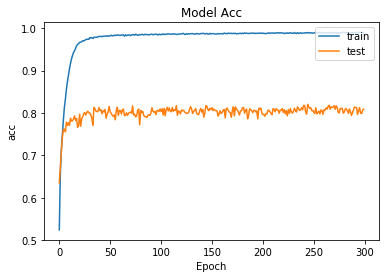

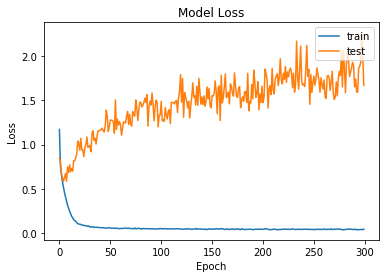

In [3]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [5]:
new_model = load_model('E:/output/bikes-cnn-SqueezeNet-Class/00300.hdf5')

true_label = []
predicted_label = []
for index in test_indices:
    msrp = prices[index]
    true_label.append(str(msrp))
    
    path = image_paths[index]
    img = image.load_img(path, target_size=(224, 224))
    data = np.expand_dims(image.img_to_array(img), axis=0)
    
    # Prediction outputs softmax vector
    prediction = new_model.predict(data)
    
    # Set most confident prediction as label, and convert it to our price scale
    label = np.argmax(prediction) * 25 + 25
    predicted_label.append(str(label))

from sklearn.metrics import confusion_matrix, classification_report
print("Classification report:\n%s\n"
      % (classification_report(true_label, predicted_label)))
print("Confusion matrix:\n%s" % confusion_matrix(true_label, predicted_label))


Classification report:
             precision    recall  f1-score   support

        100       0.77      0.84      0.81       496
         25       0.80      0.85      0.83       596
         50       0.72      0.64      0.67       563
         75       0.64      0.62      0.63       530

avg / total       0.73      0.74      0.73      2185


Confusion matrix:
[[418   5   4  69]
 [  2 509  71  14]
 [  2 100 358 103]
 [119  19  65 327]]
